# 3i005 - projet 3 - 2019avril -

# ANALYSE DE SEQUENCES GENOMIQUES
L’objectif de ce projet est d’utiliser des méthodes d’analyse statistiques pour extraire de l’information des données génétiques. Un génome peut être vu en première approximation comme un suite de lettre (une sorte de livre), composé de différents éléments qui sont "lus" par la cellule pour lui permettre d’accomplir ses tâches. Nous verrons comment nous pouvons par l’analyse statistique de la séquence génomique (un texte) localiser ou détecter ces éléments.

## Prélude au projet

In [59]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python

In [60]:
import projet as pj # our own code package to answer the different problematics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rappels de biologie
Les objets que nous étudions sont des génomes d’organismes vivant. En première approximation, un génome peut être vu comme une chaîne de caractère écrite dans un alphabet à 4 lettres (A,C,GouT). Depuis le début des années 90, il est devenu de plus en plus simple de <strong>séquencer</strong> un génome (le séquençage d’un génome humain coûte à  l’heure  actuelle  un  peu  moins  de  1000$).  Cependant  on  ne  peut  pas  comprendre, simplement à partir de la séquence génomique, comment cette information est utilisée par la cellule. C’est un peu comme avoir a disposition un manuel d’instructions écrit dans une langue inconnue. On doit donc <strong>décrypter</strong> un code pour comprendre le rôle des différents éléments qui sont présents le long de ce génome.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;Dans la suite nous ne considérerons que des exemples sur des organismes unicellulaire, dont les génomes sont plus compactes et dont l’analyse statistique est plus simple.Comme première approximation, on peut distinguer deux types d’éléments d’intérêt le long des génomes, les <strong>gènes</strong> et les <strong>séquences promoteurs</strong>.

## Préliminaires: données et lecture de fichiers

1 - Combien de nucléotides compte les chromosomes de S. cerevisae qui sont donnés ?

In [79]:
cerevisae = pj.read_fasta("yeast_s_cerevisae_genomic_chr1-4.fna")
count = pj.nucleotide_count(cerevisae['>NC_001133.9 Saccharomyces cerevisiae S288c chromosome I, complete sequence\n'])
result = {"A":count[0], "C":count[1], "G":count[2], "T":count[3]}
result

{'A': 59043, 'C': 41019, 'G': 41611, 'T': 58814}

2 - Estimer les fréquences des lettres sur le génome de S. cerevisae.

In [34]:
frequence = pj.nucleotide_frequency(cerevisae['>NC_001133.9 Saccharomyces cerevisiae S288c chromosome I, complete sequence\n'])
result = {"A":frequence[0], "C":frequence[1], "G":frequence[2], "T":frequence[3]}
result

{'A': 0.294497897619297,
 'C': 0.20459680677550166,
 'G': 0.207549616683376,
 'T': 0.29335567892182535}

## Annotation des régions promoteurs
Les séquences promoteurs sont des séquences généralement situées avant les gènes. La fixation d’une protéine (appelée facteur de transcription) sur une séquence d’ADN particulière en amont du gène sera responsable de sa transcription. On peut donc voir ces séquences de fixation comme des "interrupteurs" qui, quand il sont activés, lancent la production d’un gène et de la protéine correspondante suivant l’état de la cellule. En terme de séquence, ces facteurs de transcription se fixent donc sur des mots de 6 à 10 lettres en général.

## Description Empirique, préliminaires
Détecter les sites de fixations avec des expériences biologiques prend beaucoup de temps et est coûteux, on veut donc pouvoir avoir des méthodes qui permettent de les connaître directement avec l’analyse de la séquence. Par contre on peut facilement détecter un ensemble de gènes qui sont activés au même moment. La question en suite est de trouver, en amont du gène, les motifs commun qui seront responsable de l’activation. Pour pouvoir prédire automatiquement les mots qui pourraient correspondre à  des  sites  de  fixation  des  facteurs  de  transcription,  nous  allons  utiliser  le  fait  que ceux ci devraient être "inattendus" eu égard à la composition en nucléotide. On part du principe que si un mot est "important" pour la cellule, il apparaitra relativement plus souvent que les autres mots de la même longueur et plus que ce qu’on attendrait au hasard. On va analyser les séquences dans les fichiers regulatory_seq_PHO.fasta, regulatory_seqs_GAL.fasta et regulatory_seqs_MET.fasta.<br/>
Pour simplifier l’analyse, on considère qu’on <strong>concatène</strong> l’ensemble des séquences dechaque fichier. On travaille donc uniquement avec une liste d’entier à chaque fois.

In [6]:
sequencePHO = pj.read_fasta("regulatory_seq_PHO.fasta")
sequenceGAL = pj.read_fasta("regulatory_seqs_GAL.fasta")
sequenceMET = pj.read_fasta("regulatory_seqs_MET.fasta")

1a - Ecrire une fonction code(m, k) qui renvoie pour un mot m de taille k son
indice dans le tableau ordonné lexicographiquement.

In [7]:
pj.code('TAC',3)

49

1b - Ecrire la fonction inverse

In [8]:
pj.inverse(49,3)

'TAC'

1c - Ecrire la fonction qui compte le nombre d’occurrences pour tous les mots de
taille k dans une séquence d’ADN.

In [9]:
#Exemple pour k=2
pj.count_word(2, sequenceMET[list(sequenceMET.keys())[0]])

{'AA': 88,
 'AC': 39,
 'AG': 35,
 'AT': 81,
 'CA': 51,
 'CC': 23,
 'CG': 20,
 'CT': 55,
 'GA': 33,
 'GC': 30,
 'GG': 20,
 'GT': 41,
 'TA': 72,
 'TC': 57,
 'TG': 48,
 'TT': 106}

2 - Ecrire une fonction
comptage_attendu qui prend en paramètres les fréquences des nucléotides, k, et
la longueur du génome l et renvoie les comptages attendus pour tous les mots de
longueur k.

Si on connait les fréquences des lettres dans le génome, alors le nombre attendu d’occurrences pour un mot $w$ dans une séquence de longueur $l$ se calcule de la manière suivante:
On récupère le produit des fréquences de chaque nucléotide (les fréquences sont connues) que l'on multiplie à la taille $l-k+1$ de la séquence moins celle du motif:

$$(l-k+1)\times \prod_{nucleotide \in w} frequence(nucleotide)$$

In [10]:
pj.comptage_attendu([0.25,0.25,0.49,0.01], 1, 100)

{'A': 25.0, 'C': 25.0, 'G': 49.0, 'T': 1.0}

3 - Afficher avec un graphique 2D le nombre attendu d’occurrences sur l’axe des abcisses
et le nombre observé sur l’axe des ordonnées pour tout les mots de longueur
k pour les séquences PHO, GAL et MET.

In [11]:
#preparation
def completeSequence(sequence):
    complet = []
    for k in sequence.keys():
        complet = complet + sequence[k]
    sequence["complet"] = complet

completeSequence(sequencePHO)
completeSequence(sequenceGAL)
completeSequence(sequenceMET)

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


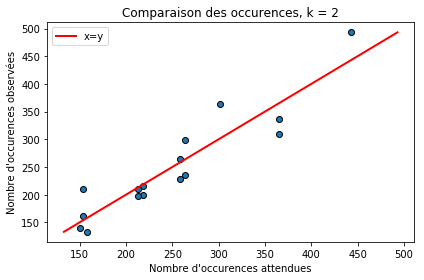

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


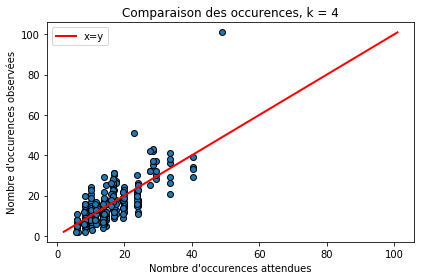

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


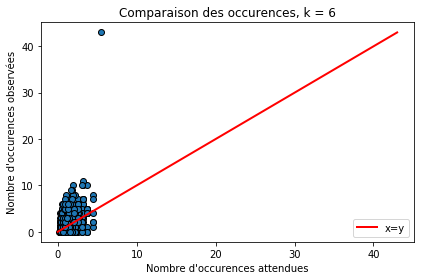

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


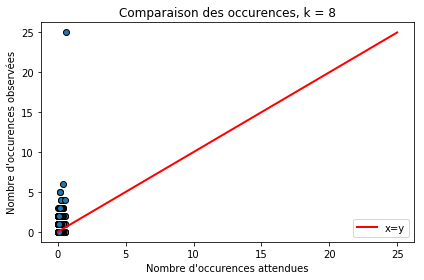

In [12]:
pj.graphique(2, sequencePHO["complet"])
pj.graphique(4, sequencePHO["complet"])
pj.graphique(6, sequencePHO["complet"])
pj.graphique(8, sequencePHO["complet"])
#On testera avec k = 2, 4, 6, 8.

##  Simulation de séquences aléatoires
On veut évaluer la validité de nos calcul de probabilités empiriques à l’aide de simulations.
On va simuler un grand nombre de séquences aléatoire et comparer la probabilité
obtenue avec la valeur observée.

1 - Ecrire une fonction simule_sequence(lg, m) qui génère une séquence aléatoire
de longueur lg d’une composition donnée m (proportion de A, C, G et T).

In [13]:
pj.count_word(1, pj.simule_sequence(100, [0.3, 0.01, 0.345, 0.345]))

{'A': 26, 'C': 4, 'G': 37, 'T': 33}

2 - Avec la fonction de simulation de séquences, simuler plusieurs séquences pour comparer le comptage attendu et le comptage observé.

In [14]:
comparaisons = []
for i in range(1000):
    comparaisons.append(pj.compare(4, pj.simule_sequence(100, [0.3, 0.01, 0.345, 0.345])))
np.mean([comparaisons])

0.011718750000000014

3 - Utilisez les simulations pour estimer
la probabilité empirique des mots ATCTGC, ATATAT, TTTAAA ou AAAAAA.

In [53]:
pj.probaempirique("ATCTGC",10000,frequence,boucles=100)

{2: 28, 3: 23, 1: 19, 5: 4, 4: 13, 0: 10, 6: 3}


{2: 0.28, 3: 0.23, 1: 0.19, 5: 0.04, 4: 0.13, 0: 0.1, 6: 0.03}

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


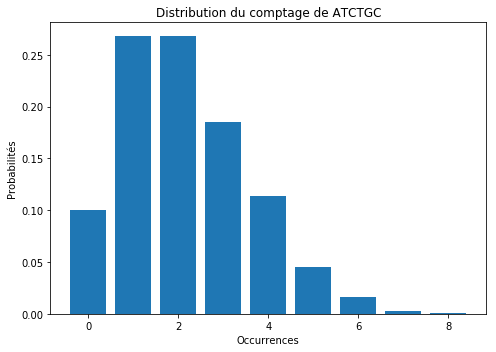

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


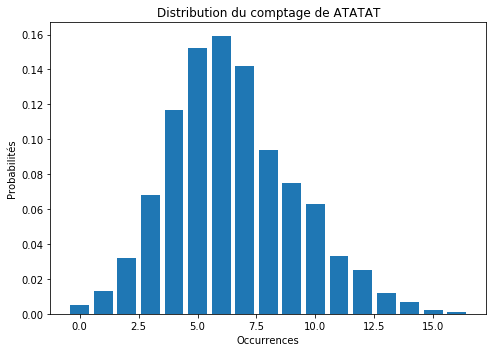

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


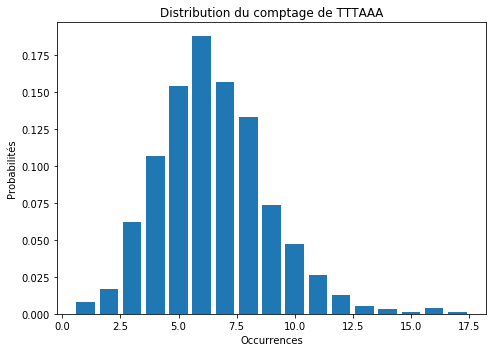

C:\Users\Pierre\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


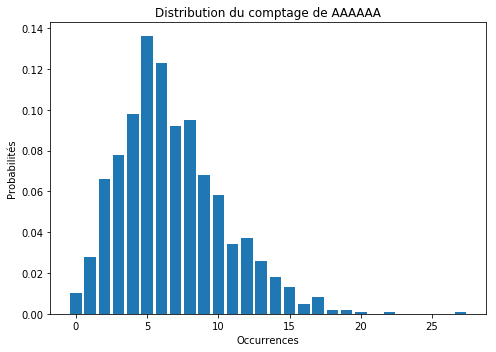

In [68]:
pj.histogramme("ATCTGC",frequence)
pj.histogramme("ATATAT",frequence)
pj.histogramme("TTTAAA",frequence)
pj.histogramme("AAAAAA",frequence)


Ces histogrammes sont basés sur les fréquences nucléotidiques du génome de S. cerevisae.

On observe des distributions plus étendues chez les 3 derniers motifs (AAAAAA, TTTAAA et ATATAT): La probabilité de trouver ces motifs 10 fois dans une séquence du  génome de S. cerevisae est environ égale à 0.02 pour ces motifs tandis que pour ATCTGC, nous n'avons pas observé le motif plus de 8 fois. Néanmoins la probabilité de trouver le motif 2 fois est de 0.25 pour ATCTGC tandis que la probabilité maximale pour une occurence donnéee chez les trois autres est entre 0.14 et 0.175. 
Ces chiffres veulent donc dire que l'on a pas beaucoup de chance de trouver le motif ATCTGC de nombreuses fois, mais qu'on en a beaucoup plus de le trouver 2 ou 3 fois, ce motif pourrait donc être important puisqu'il serait rare de ne pas l'obtenir dans une séquence (suffisament longue). Tandis que les trois autres motifs "simples" ont dans l'ensemble des probabilités plus faibles mais beaucoup plus d'occurences, ces motifs sont assez courant dans la séquence.

## Modèles de dinucléotides et trinucléotides

1-Est ce que ce modèle correspond à une chaîne de Markov ? De quel ordre ? A quoi
correspond la probabilité stationnaire ?


Ce modèle correspond à une chaîne de Markov d'ordre 1 : on regarde le dernier nucléotide pour déterminer le suivant. La probabilité stationnaire est le vecteur qui correspond aux fréquences des nucléotides de la séquence.

2 - Ecrire une fonction qui estime M à partir des comptages des mots de longueur 2.

In [82]:
mat = pj.estimMatrice(cerevisae['>NC_001133.9 Saccharomyces cerevisiae S288c chromosome I, complete sequence\n'])
mat

array([[0.31802246, 0.19514591, 0.20647664, 0.280355  ],
       [0.33574685, 0.21148736, 0.16411907, 0.28864672],
       [0.30463099, 0.20230228, 0.21088174, 0.282185  ],
       [0.23494806, 0.21088875, 0.23656334, 0.31759985]])

Estimation de la matrice M à partir des comptages des mots de longueur 2 du génome de S.cerevisiae

3. Ecrire une fonction qui simule une séquence de longueur l avec le modèle de dinucléotides.


In [83]:
pj.simule_markov(100,mat)

'0120103032032122130131031302210112222333323313123011301000313310202203013310331003330201302213330033'

4. Calculez la probabilité d’apparition d’un mot à une position donnée (rappel : pour
les fréquences de nucléotides, c’est le produit des probabilités des lettres).


Soit le mot $m$ constitué de $l$ nucléotides, la probabilité d'apparition du mot $m$ correspond au produit suivant:

$Frequence(m_{0})\times P(m_{1}|m_{0})\times \cdots \times P(m_{l} |m_{l-1})$

Où fréquence correspond aux vecteurs des fréquences des différents nucléotides et $\forall i \le l,m_{i}$ est un nucléotide. On s'en sert uniquement pour déterminer le premier nucléotide, les nucléotides restants sont déterminés grâce à la matrice de transition.

In [89]:
pj.proba_apparition("AT", mat)

0.2803549955117457


0.07008874887793642

5. Quel est le nombre attendu d’occurrences pour un mot de longueur k avec le
modèle de dinucléotides ?

C'est la probabilité estimée dans la question précédente, multiplié par la taille de la séquence moins celle du motif(pour que la taille de la séquence avec le motif soit égale à $l$. 

$$(l-k+1)\times \prod_{i}^{l-k+1} P(nucleotide_{i})$$

6. *Comparez les comptages du nombre d’occurrences entre le modèle de nucléotides
et de dinucléotides.


In [95]:
print(pj.nbr_occurences(mat,2,100,frequence))
print(pj.comptage_attendu(frequence,2,100))

{'AA': 9.27203758847207, 'AC': 5.689535979888971, 'AG': 6.019886576186985, 'AT': 8.17383171976238, 'CA': 6.800580586272427, 'CC': 4.28369420461177, 'CG': 3.3242454622993014, 'CT': 5.8465636175911655, 'GA': 6.259378413562974, 'GC': 4.156788220682638, 'GG': 4.33307396489548, 'GT': 5.79817145251313, 'TA': 6.823411292789629, 'TC': 6.124675804347212, 'TG': 6.8703228626850565, 'TT': 9.223802253438812}
{'AA': 8.586172158516408, 'AC': 5.965079616045671, 'AG': 6.051169650729575, 'AT': 8.55287043901875, 'CA': 5.965079616045671, 'CC': 4.144125480930464, 'CG': 4.203934893268913, 'CT': 5.941943880529616, 'GA': 6.051169650729575, 'GC': 4.203934893268913, 'GG': 4.2646074951562145, 'GT': 6.027700012499521, 'TA': 8.55287043901875, 'TC': 5.941943880529616, 'TG': 6.027700012499521, 'TT': 8.519697881212824}


Les comptages sont légèrement différents.